In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")

In [9]:
df_train.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

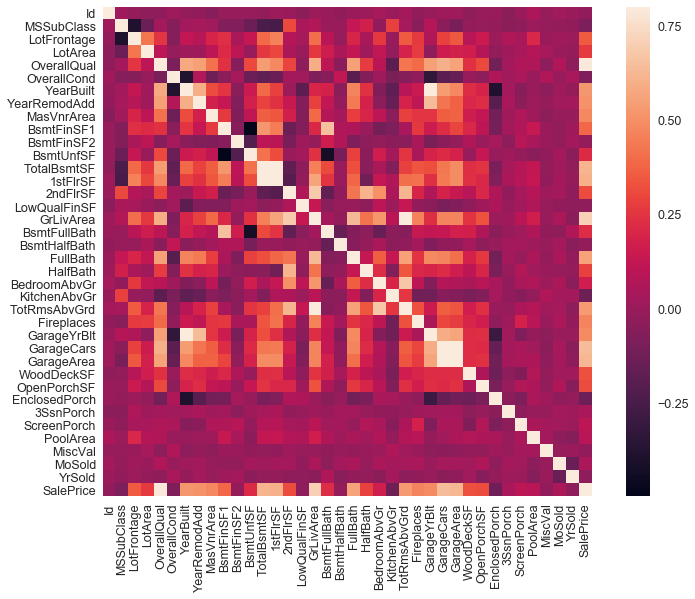

In [10]:
#show correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

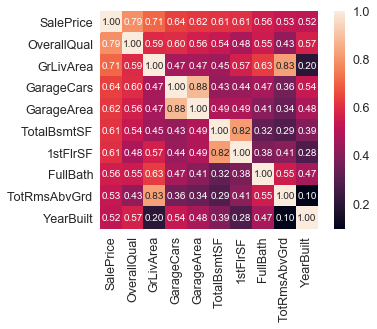

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [12]:
n_folds = 5
scorer = make_scorer(mean_squared_error,greater_is_better = False)

noSP = df_train.filter(['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt'])
trainables = np.matrix(noSP)
salePrice = np.array(df_train['SalePrice'])


x_train,x_test,y_train,y_test = train_test_split(trainables,salePrice,test_size = 0.3,random_state= 0)

lr = LinearRegression()
lr.fit(x_train,y_train)
predictions = lr.predict(x_test)

cross_val = cross_val_score(lr,x_test,y_test)

print(cross_val.mean())

0.6123433397160171


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 180921.20 and sigma = 79415.29



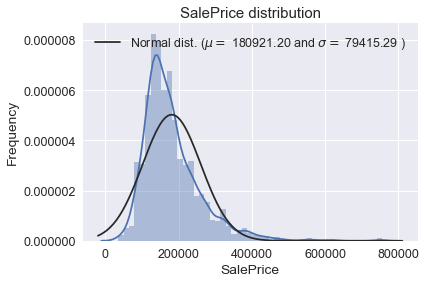

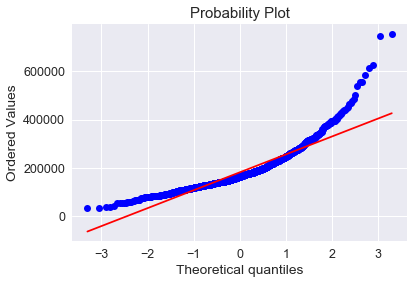

In [14]:

from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [15]:
all_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))

In [16]:
#log transform the target:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [17]:
all_data = pd.get_dummies(all_data)

In [18]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [20]:
#creating matrices for sklearn:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
y = df_train.SalePrice

In [21]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [22]:
model_ridge = Ridge()

In [23]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

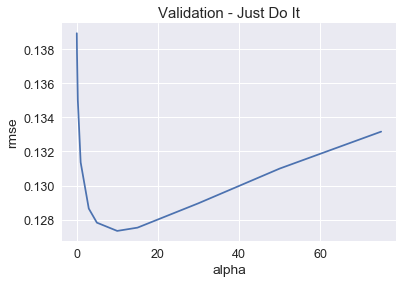

In [24]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [25]:
cv_ridge.min()

0.12733734668670776

In [26]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [27]:
rmse_cv(model_lasso).mean()

0.12314421090977432

In [28]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [29]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [31]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Text(0.5,1,'Coefficients in the Lasso Model')

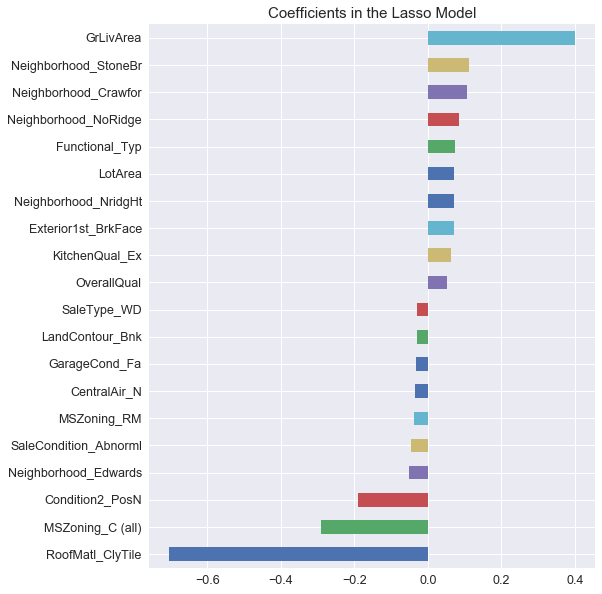

In [33]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

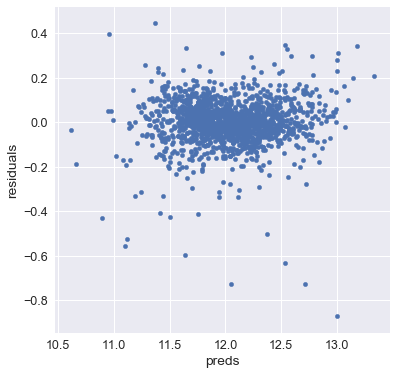

In [35]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [39]:
n_folds = 5
scorer = make_scorer(mean_squared_error,greater_is_better = False)

noSP = df_train.filter(['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt'])
trainables = np.matrix(noSP)
salePrice = np.array(df_train['SalePrice'])


x_train,x_test,y_train,y_test = train_test_split(trainables,salePrice,test_size = 0.3,random_state= 0)

lr = LinearRegression()
lr.fit(x_train,y_train)
predictions = lr.predict(x_test)

cross_val = cross_val_score(lr,x_test,y_test)

print(cross_val.mean())

0.7324910400744402


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 12.02 and sigma = 0.40



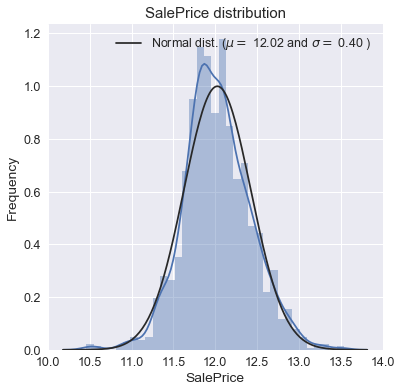

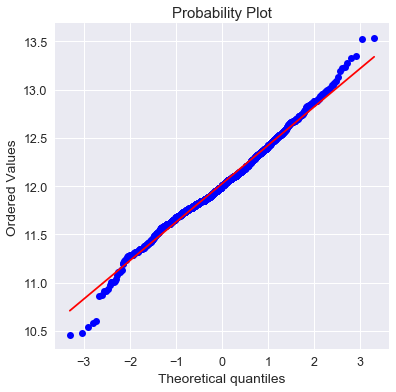

In [38]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()